<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/STNexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

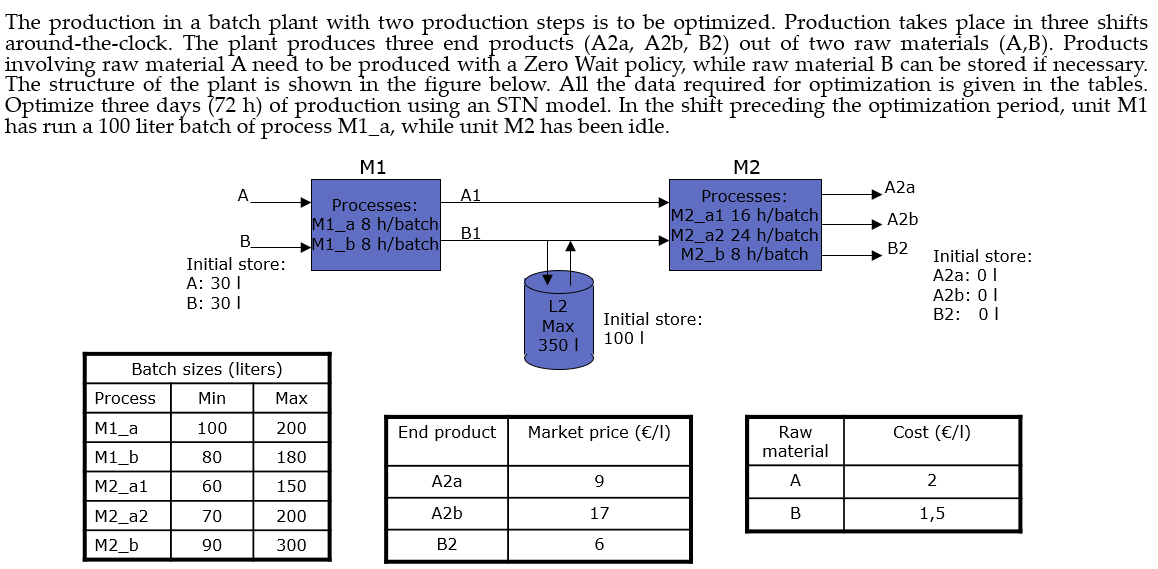

In this exercise we will enter the sets from an excel file. The set of time slots will be created separately. Finally we will analyze the results using plotly. Drag the excel-file you have filled with the sets and parameters to the virtual machine you are working on. Use the file manager icon

 image.png

 This must be repeated every time you start a new machine.

 First we install solvers and pyomo. Here we install both cbc and Highs so that their performance can be compared.

In [1]:
#This  installs pyomo and the MILP solvers cbc and  Highs
#The print out during installation indicates that highpy is already installed?

try:
  not_first_time == True
except:
  !pip install -q pyomo
  !apt-get install -y -qq coinor-cbc
  !pip install highspy
  not_first_time = True
finally:
  print("Pyomo and solvers installed")

#Pyomo as star import. Also import packages needed for Gantt-chart
from pyomo.environ import *
from pyomo.contrib.appsi.solvers.highs import Highs
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import datetime as dt

Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to unpack .../4-coinor-libcbc3_2.10.7+ds1-1_amd64.deb ...
Unpacking coinor-libcbc3:

We create our pyomo model object

In [2]:
mod=ConcreteModel()

In this implementation we use a Pyomo set for time. These sets are by default ordered. Here it is enforced for backward compability. The members in the set will be strings. The indices will be named t+day+shift, e.g., t11. As the last member we append a time slot named tfinal, for the time slot after our time horizon. This is needed to store the states produced at the end of our time horizon.

We create the list using list comprehension `[x for x in x]` and `str(number)` to convert numbers to string.

In [3]:
#create members for the set of time slot (range(1,4)=1,2,3!)
t=['t'+str(i)+str(j) for i in range(1,4) for j in range(1,4)]
#alternative just using the time slot number
#t=[t for t in range(1,3*3+1)]
t.append('tfinal')
mod.t=Set(initialize=t,ordered=True,doc='Time slots')
td = 1 #length of a discretization step in hours

Check the set of time slots using pretty-print method .pprint() on mod.t

In [4]:
mod.t.pprint()

t : Time slots
    Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   10 : {'t11', 't12', 't13', 't21', 't22', 't23', 't31', 't32', 't33', 'tfinal'}


We read in our Excel files into a data frame using pandas. Excel will have cells defined in the regions you have been working. In this example the empty cell with borders causes "NaN"-elements.

In [7]:
# everything else in from the Excel file into a date frame from pandas
df = pd.read_excel('STNex-full.xlsx')

You can check how the data frame looks like by running its name

In [8]:
df

,s,S_0,C_s,C_st,s_raw,s_final,i,p_i,p_is,j,...,Vmin,Vmax,Ki_j,Ki_i,Tbar_s_i,Tbar_s_s,ro_bar,T_s_i,T_s_s,ro
0,A,30,1000,2.0,A,A2a,M1_a,1.0,1.0,M1,...,100.0,200.0,M1,M1_a,M1_a,A1,1.0,M1_a,A,1.0
1,B,30,1000,1.5,B,A2b,M1_b,1.0,1.0,M2,...,80.0,180.0,M1,M1_b,M1_b,B1,1.0,M1_b,B,1.0
2,A1,100,0,NaN,NaN,B2,M2_a1,2.0,2.0,NaN,...,60.0,150.0,M2,M2_a1,M2_a1,A2a,1.0,M2_a1,A1,1.0
3,B1,100,350,NaN,NaN,NaN,M2_a2,3.0,3.0,NaN,...,70.0,200.0,M2,M2_a2,M2_a2,A2b,1.0,M2_a2,A1,1.0
4,A2a,0,5000,9.0,NaN,NaN,M2_b,1.0,1.0,NaN,...,90.0,300.0,M2,M2_b,M2_b,B2,1.0,M2_b,B1,1.0
5,A2b,0,5000,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,B2,0,5000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we use the data in the data frame to create lists that we can use to initialize our sets. We use the name of the column(s) as identifier(s) and use notnull() to skip empty cells with "NaN". First, we do this for the one-dimensional sets.


In [9]:
#create sets from the elements in df column that are not 'NaN'
s = [s for s in df.set_index('s').index.values if pd.notnull(s)]
mod.s=Set(initialize=s,doc='State')

sraw = [s for s in df.set_index('s_raw').index.values if pd.notnull(s)]
sfinal = [s for s in df.set_index('s_final').index.values if pd.notnull(s)]
mod.S_raw=Set(within=mod.s,initialize=sraw,doc='state s being raw material')
mod.S_final=Set(within=mod.s,initialize=sfinal,doc='state s procuct')

i = [i for i in df.set_index('i').index.values if pd.notnull(i)]
j = [j for j in df.set_index('j').index.values if pd.notnull(j)]
mod.i=Set(initialize=i, doc='Task')
mod.j=Set(initialize=j, doc='Units')

Check the model by using `mod.pprint()` or an individual part of it, e.g., the units.

In [10]:
mod.pprint()

6 Set Declarations
    S_final : state s procuct
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :      s :    3 : {'A2a', 'A2b', 'B2'}
    S_raw : state s being raw material
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :      s :    2 : {'A', 'B'}
    i : Task
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'M1_a', 'M1_b', 'M2_a1', 'M2_a2', 'M2_b'}
    j : Units
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'M1', 'M2'}
    s : State
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    7 : {'A', 'B', 'A1', 'B1', 'A2a', 'A2b', 'B2'}
    t : Time slots
        Size=1, Index=None, Ordered=Insertion
        Key  : 

We do the same for two dimensional sets. Now we need to read two columns at a time and are only interested in those rows where both have values.


In [11]:
#the same for two-dimensional
Ij=[(i,j) for (i,j) in df.set_index(['Ij_i','Ij_j']).index.values
    if pd.notnull(i) and pd.notnull(i)]
Ki=[(j,i) for (j,i) in df.set_index(['Ki_j','Ki_i']).index.values
    if pd.notnull(j) and  pd.notnull(i)]
Tbar_s=[(i,s) for (i,s) in df.set_index(['Tbar_s_i','Tbar_s_s']).index.values
    if pd.notnull(i) and  pd.notnull(s)]
T_s=[(i,s) for (i,s) in df.set_index(['T_s_i','T_s_s']).index.values
    if pd.notnull(i) and  pd.notnull(s)]
mod.I_j=Set(within=mod.i*mod.j,initialize=Ij,doc='Task i performed on unit j')
mod.K_i=Set(within=mod.j*mod.i,initialize=Ki,doc='Units j capable of task i')
mod.Tbar_s=Set(within=mod.i*mod.s,initialize=Tbar_s,doc='Task i producing s')
mod.T_s=Set(within=mod.i*mod.s,initialize=T_s,doc='Task i consuming s')

Next we use our data to initialize parameters. First, we initialize one-dimensional parameters. Here also we need to read two columns. We then need to reorder them so that one is the index and the other the parameter value of that index. The parameter $p_i$ and later also $p_{is}$ are set to integer, as they are used in checking time slots in the model.

In [12]:
#parameter values from data frame
p=[(i,p) for (i,p) in df.set_index(['i','p_i']).index.values
    if pd.notnull(i) and pd.notnull(p)]
p_i={}
for (i,v) in p:
    p_i[i]=int(v)
mod.p_i = Param(mod.i, initialize=p_i, default=0,doc='production time (in steps) for task i')

C=[(s,p) for (s,p) in df.set_index(['s','C_s']).index.values
    if pd.notnull(s) and pd.notnull(p)]
C_s={}
for (s,p) in C:
    C_s[s]=p
mod.C_s = Param(mod.s, initialize=C_s, default=0,doc='storage capacity for state s')

C=[(s,p) for (s,p) in df.set_index(['s','C_st']).index.values
    if pd.notnull(s) and pd.notnull(p)]
C_st={}
for (s,p) in C:
    C_st[s]=p
mod.C_st = Param(mod.s, initialize=C_st, default=0,doc='cost of state s')

S=[(s,p) for (s,p) in df.set_index(['s','S_0']).index.values
    if pd.notnull(s) and pd.notnull(p)]
S_0={}
for (s,p) in S:
    S_0[s]=p
mod.S_0 = Param(mod.s, initialize=S_0, default=0, doc='start level')

We then initialize the two-dimensional parameters. Here we first need to read three columns and reorder.


In [13]:
#parameter for two-D set fom data frame
V=[(i,j,p) for (i,j,p) in df.set_index(['Ij_i','Ij_j','Vmin']).index.values
    if pd.notnull(i) and pd.notnull(j) and pd.notnull(p)]
Vmin={}
for (i,j,v) in V:
    Vmin[i,j]=v
mod.Vmin = Param(mod.i, mod.j, initialize=Vmin, default=0, doc='min batch size')

V=[(i,j,p) for (i,j,p) in df.set_index(['Ij_i','Ij_j','Vmax']).index.values
    if pd.notnull(i) and pd.notnull(j) and pd.notnull(p)]
Vmax={}
for (i,j,v) in V:
    Vmax[i,j]=v
mod.Vmax = Param(mod.i, mod.j, initialize=Vmax, default=0, doc='max batch size')

The parameters ro_bar, ro and p_is ($\bar{\rho}_{i,s}$, $\rho_{i,s}$and $p_{i,s}$) are read from the file and defined.

In [14]:
ro_b=[(i,s,p) for (i,s,p) in df.set_index(['Tbar_s_i','Tbar_s_s','ro_bar']).index.values
    if pd.notnull(i) and pd.notnull(s) and pd.notnull(p)]
ro_bar={}
for (i,s,p) in ro_b:
    ro_bar[i,s]=p
mod.ro_bar = Param(mod.i, mod.s, initialize=ro_bar, default=0, doc='Fraction of batch of i producing state s')

r=[(i,s,p) for (i,s,p) in df.set_index(['T_s_i','T_s_s','ro']).index.values
    if pd.notnull(i) and pd.notnull(s) and pd.notnull(p)]
ro={}
for (i,s,p) in r:
    ro[i,s]=p
mod.ro = Param(mod.i, mod.s, initialize=ro, default=0, doc='Fraction of batch of i consisting of state s')

p_s=[(i,s,p) for (i,s,p) in df.set_index(['Tbar_s_i','Tbar_s_s','p_is']).index.values
    if pd.notnull(i) and pd.notnull(s) and pd.notnull(p)]
p_is={}
for (i,s,p) in p_s:
    p_is[i,s]=int(p)
mod.p_is = Param(mod.i, mod.s, initialize=p_is, default=0,doc='Availability time (in steps) for state i produced in task i')



We define a Big-M. *Ij* is all tasks on all units. If we multiply the cardinality of this set with the cardinality of the time slot set we should have a big enough Big-M.

In [15]:
mod.BigM = Param(initialize=len(Ij)*len(t), doc='Big-M for overlap constraint')

We then define all variables. This is a model without the blocking constraints, the utility restriction constraints and the setup-time constraints. Also, there is no delivery of products during the optimization time horizon, but we can buy raw material as needed. Blocking, utilities and deliveries would add extra variables (and parameters).

In [16]:
#Positive variables
mod.B = Var(mod.i,mod.j,mod.t,within=NonNegativeReals,doc="batch size of task i in unit j in time step t ")
mod.S = Var(mod.s,mod.t,within=NonNegativeReals,doc="amount of state s in time step t ")
mod.R = Var(mod.S_raw,mod.t,within=NonNegativeReals,doc="amount of state s in s_raw purchased in time step t ")

#Binary variables
mod.W = Var(mod.i,mod.j,mod.t,within=Binary,doc="batch of task i in unit j in timestep t ")

We can now define the STN model starting with the objective function. Here, we account for costs of buying raw materials. (One could/should include costs for usage of raw materials in storage as well.)

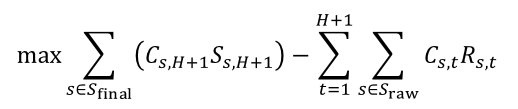

In this case the costs/values are not time-dependent, although the model equations say so.  Note: We have named the parameter giving the cost/value of a state in the code C_st.

In [17]:
def obj_rule(mod):
    return sum(mod.C_st[s]*mod.S[s,'tfinal'] for s in mod.S_final)- \
           sum(mod.C_st[s]*mod.R[s,t] for t in mod.t for s in mod.S_raw)

mod.o = Objective(rule=obj_rule, sense=maximize)

The next constraint is more complicated to implement. We have requirements on *i'* and the time summation should only be for a certain interval. Note that the $\forall i \in I_{j}$ is handled by sending the two dimensional set to the function (where it is unpacked to *i* and *j*).

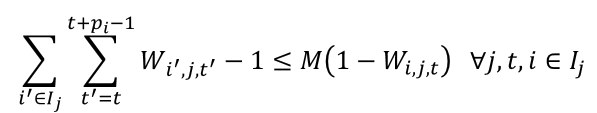


In [18]:
def overlap_rule(mod,i,j,t):
    return (sum(mod.W[ip,j,tp] for ip in mod.i if (ip,j) in mod.I_j \
                for tp in mod.t if (mod.t.ord(tp) >= mod.t.ord(t)) and (mod.t.ord(tp) <= mod.t.ord(t)+mod.p_i[i]-1))) \
                -1 <=mod.BigM*(1-mod.W[i,j,t])

mod.overlap = Constraint(mod.I_j, mod.t, rule=overlap_rule, doc='No overlap in reactor usage')

Do not start any task that finishes later that time step tfinal.
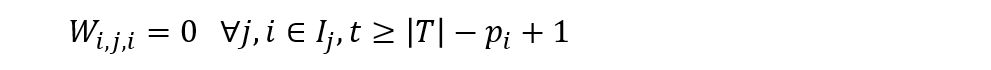

In [19]:
#do not start a process that does not finalize

def dont_rule(mod,i,j,t):
    if mod.t.ord(t) >= len(mod.t) - mod.p_i[i] + 1:
        return mod.W[i,j,t] == 0
    else:
        return Constraint.Skip

mod.dont = Constraint(mod.I_j, mod.t, rule=dont_rule, doc='Do not start a batch that does not get ready')

Batch limitations. In some cases the solving time increases significantly if the lower limit is not zero. This is because without a limit, one can have a batch of size zero but still run it.


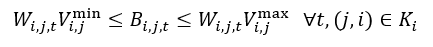

Although it would be possible to specify both upper and lower limits of a constraint in Pyomo, we split this into two for the sake of clarity. Here, the requirement of combinations of *j* and *i* can be handled with the two-dimensional set as input to the constraint.

Note. The set $K_i$ is used in the Constraint function. This consists of pairs $(j,i)$ so the input to the rule is `(mod,j,i,t)`.

In [20]:
def vmin_rule(mod,j,i,t):
    return mod.B[i,j,t] >= mod.Vmin[i,j]*mod.W[i,j,t]

mod.batchmin = Constraint(mod.K_i, mod.t, rule=vmin_rule, doc='Min batch size')

def vmax_rule(mod,j,i,t):
        return mod.B[i,j,t] <= mod.Vmax[i,j]*mod.W[i,j,t]

mod.batchmax = Constraint(mod.K_i, mod.t, rule=vmax_rule, doc='Max batch size')

Constraint for limiting the amount of a state stored. If we had blocking we would separate between storing in the unit and in the storage. We could add a lower limit on the storage, but then we would need to start the model with at least the minimum level required.

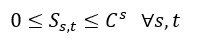

In [21]:
def storage_rule(mod,s,t):
    return mod.S[s,t] <= mod.C_s[s]

mod.storage = Constraint(mod.s, mod.t, rule=storage_rule, doc='Max storage capacity')

 Only raw-materials can be bought, so we have two different sets of this constraint. The constraint is $\forall t$, but the first sum in the constraint should only be included if $t-p_{i,s}$ is $\ge 1 $. Here, the two double sums are calculated separately and reused. Since the indices are strings we need to use `ord()` to get the position in the Pyomo-set and then `at()` to get the item at the position we use as function input.
 In the first time step we take from the storage (although we could buy raw material as well). The equations become:
 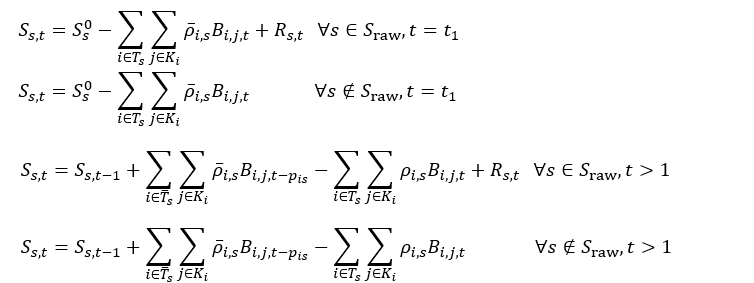


In [22]:
def mass_rule(mod,s,t):
  sum1=sum(mod.ro_bar[i,s]*mod.B[i,j, mod.t.at(mod.t.ord(t)-mod.p_is[i,s])] for (j,i) in mod.K_i if (i,s) in mod.Tbar_s if (mod.t.ord(t)-mod.p_is[i,s]) >= 1 )
  sum2=sum(mod.ro[i,s]*mod.B[i,j,t] for (j,i) in mod.K_i if (i,s) in mod.T_s)

  if (mod.t.ord(t) == 1):
      if (s in mod.S_raw):
          return mod.S[s,t] == mod.S_0[s]  -sum2 + mod.R[s,t]
      else:
          return mod.S[s,t] == mod.S_0[s] - sum2
  elif mod.t.ord(t) >= 2:
      if (s in mod.S_raw):
          return mod.S[s,t] == mod.S[s,mod.t.prev(t)] + sum1 -sum2 + mod.R[s,t]
      else:
          return mod.S[s,t] == mod.S[s,mod.t.prev(t)] + sum1 -sum2

mod.massbalance = Constraint(mod.s, mod.t, rule=mass_rule, doc='Mass balance for states')

Then we solve. Here we use tee=False to keep the solver quiet. A time restriction is added just in case, but this should go fast. Also print out the value of the objective function.

In [23]:
solver = SolverFactory('cbc',executable='/bin/cbc')
solver.options['seconds']=100
results = solver.solve(mod,tee=False)

print('The profit is :', mod.o.expr(),'€')


The profit is : 9555.0 €


Use Plotly to create a bar-diagram showing the inventory of states as a function of time.

In [24]:
fig = go.Figure()
for s in mod.s:
  fig.add_trace(go.Bar(
    x=[t for t in mod.t],
    y=[mod.S[s,t].value for t in mod.t],
    name=s,
#    marker_color='indianred'
  ))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()

Finally, produce a Gantt scheme also using Plotly. There is first some code to get the time in hours and for collecting data to plot

In [25]:
#We need the start time of each time interval for the Gantt-chart, all slots 8h
hstart={t:td*mod.t.ord(t)-td for t in mod.t}

#create an empty list
d=[]
#populate the list with dictionaries
#time has to be dates in plotly. Usually convenient, but here we need to force
#the time to a data. Assuming time in hours, must be an integer.

#today=dt.datetime.now()
today=dt.datetime(2026,3,1)

for (i,j) in mod.I_j:
  for t in mod.t:
    if mod.W[i,j,t].value > 0.99: #W is binary, but saying == 1 is risky!
      start = today+dt.timedelta(hours=hstart[t])
      end = today+dt.timedelta(hours=hstart[t]+td*mod.p_i[i]) #p_i is slots
      d.append({'Task':i, 'Start':start, 'Finish':end,'Duration':p_i[i],'Size':mod.B[i,j,t].value, 'Unit':j})


df = pd.DataFrame(d)
df

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Unit", hover_data=["Task","Duration","Size"],
                  color="Task",category_orders={'Unit':[j for j in mod.j]})
fig.show()

Solve the model with the Highs solver instead of cbc and plot the results. By default this solver has a slightly larger tolerance, which is beneficial for solution time, but in the worst case it can cause other problems.

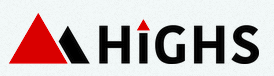

In [26]:
#Using Highs as solver instead, model already defined

solver = Highs()
solver.highs_options = {"time_limit": 100}
results = solver.solve(mod)
print('The profit is :', mod.o.expr(),'€')

fig = go.Figure()
for s in mod.s:
  fig.add_trace(go.Bar(
    x=[t for t in mod.t],
    y=[mod.S[s,t].value for t in mod.t],
    name=s,
#    marker_color='indianred'
  ))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.show()
#We need the start time of each time interval for the Gantt-chart, all slots 8h
hstart={t:td*mod.t.ord(t)-td for t in mod.t}

#create an empty list
d=[]
#populate the list with dictionaries
#time has to be dates in plotly. Usually convenient, but here we need to force
#the time to a data. Assuming time in hours, must be an integer.

#today=dt.datetime.now()
today=dt.datetime(2026,3,1)

for (i,j) in mod.I_j:
  for t in mod.t:
    if mod.W[i,j,t].value > 0.99:
      start = today+dt.timedelta(hours=hstart[t])
      end = today+dt.timedelta(hours=hstart[t]+td*mod.p_i[i]) #p_i is slots
      d.append({'Task':i, 'Start':start, 'Finish':end,'Duration':p_i[i],'Size':mod.B[i,j,t].value, 'Unit':j})


df = pd.DataFrame(d)
df

fig = px.timeline(df, x_start="Start", x_end="Finish", y="Unit", hover_data=["Task","Duration","Size"],
                  color="Task",category_orders={'Unit':[j for j in mod.j]})
fig.show()

The profit is : 9555.0 €
